# Spatial query

## Overview

In this tutorial, we will learn how to filter SpatialData datasets by coordinate system and spatial queries. This is useful for selecting regions of interest for more in-depth processing and for generating visualizations. We will use a Visium dataset as an example in which we first select data by coordinate system and then by a bounding box.

## Load the data

First, we will load the Visium dataset. You can download the data [here](https://s3.embl.de/spatialdata/spatialdata-sandbox/visium.zip). After loading the dataset, inspect the resulting {class}`spatialdata.SpatialData` object. We see there are data from two Visium slides (i.e., two image and shapes pairs). The `Images` are the H&E images and the `Shapes` are the Visium spots. The sequence data from the spots are stored in the `Table`.

In [3]:
import matplotlib.patches as patches
import spatialdata as sd
import spatialdata_plot
from matplotlib import pyplot as plt

In [4]:
sdata = sd.read_zarr("visium.zarr")
print(sdata)

SpatialData object with:
├── Images
│     ├── 'ST8059050_image': SpatialImage[cyx] (3, 2000, 1968)
│     └── 'ST8059051_image': SpatialImage[cyx] (3, 2000, 1963)
├── Shapes
│     ├── 'ST8059050_shapes': GeoDataFrame shape: (3497, 2) (2D shapes)
│     └── 'ST8059051_shapes': GeoDataFrame shape: (2409, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 5906 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'annotating', 'library', 'spot_id'
    uns: 'spatialdata_attrs': AnnData (5906, 31053)
with coordinate systems:
▸ 'ST8059050', with elements:
        ST8059050_image (Images), ST8059050_shapes (Shapes)
▸ 'ST8059051', with elements:
        ST8059051_image (Images), ST8059051_shapes (Shapes)


/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## Plotting the data
We can plot data and see that the visium spots from both datasets. We see that the two datasets are in separate coordinate systems. 

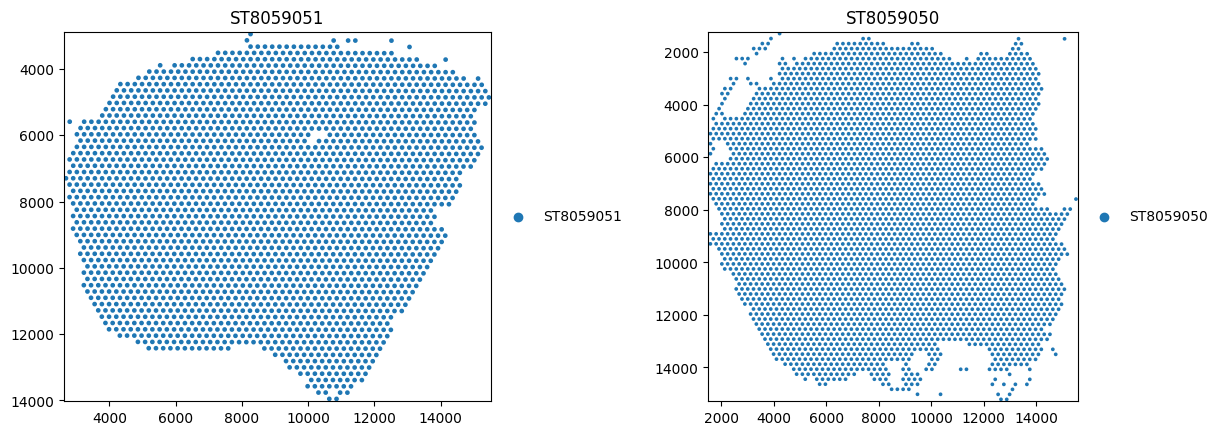

In [25]:
sdata.pl.render_shapes(color="library").pl.show()

## Filtering by coordinate system

For the remainder of this exercise, we will focus on the data from the library `ST8059050`. We can extract all of the data in our {class}`spatialdata.SpatialData` dataset related to {class}`spatialdata.SpatialData` by filtering by coordinate system. You can do so by calling the {meth}`spatialdata.SpatialData.filter_by_coordinate_system` method on the {class}`spatialdata.SpatialData` object and providing the desired coordinate system (`ST8059050` in this case). When we plot the filtered dataset (`sdata_ST8059050`) we now see it only contains the data corresponding to library `ST8059050`.

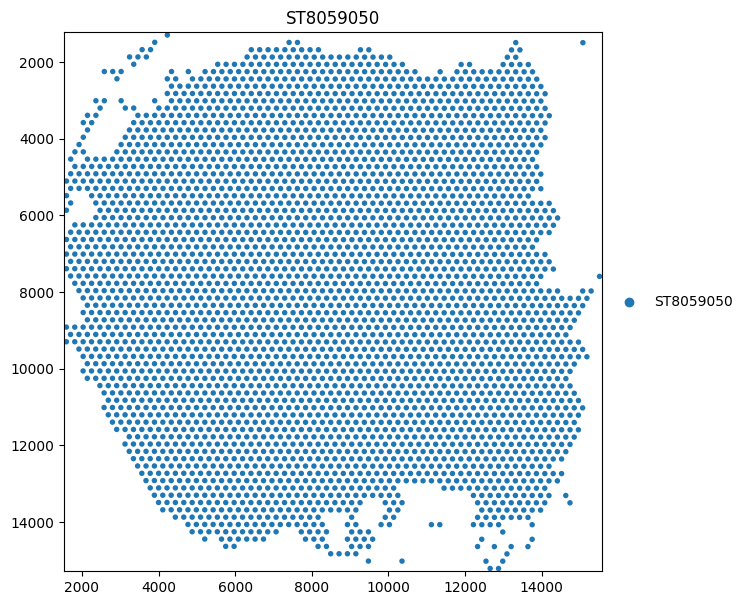

In [15]:
sdata_ST8059050 = sdata.filter_by_coordinate_system("ST8059050")

f, ax = plt.subplots(figsize=(7, 7))
sdata_ST8059050.pl.render_shapes(color="library").pl.show(ax=ax)

## Spatial query

We can also subset our `SpatialData` objects by spatial regions via the spatial query interface. For example, we can select the data contained within the rectangular bounding box show below in black.

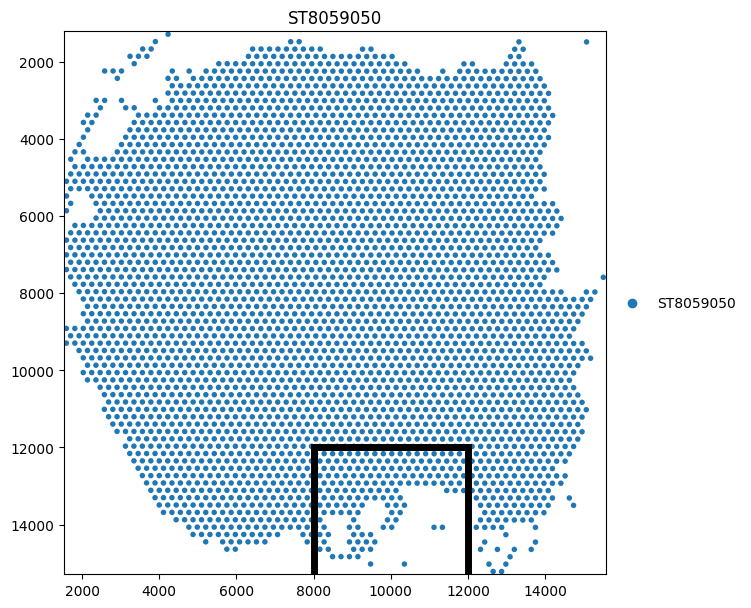

In [16]:
f, ax = plt.subplots(figsize=(7, 77))
sdata_ST8059050.pl.render_shapes(color="library").pl.show(ax=ax)
rect = patches.Rectangle((8000, 12000), 4000, 4000, linewidth=5, edgecolor="k", facecolor="none")
ax.add_patch(rect);

We can subset the `SpatialData` object via the `bounding_box` query ({meth}`spatialdata.SpatialData.query`). We must provide the minimum and maximum coordinates of the bounding box as well as the target coordintate system the bounding box coordinates correspond to. We see the resulting `cropped_sdata` object still contains the `Image`, `Shapes`, and `Table` elements, but they are all smaller. We can confirm this by plotting the resuling visium spots colored by their Sox2 expression below.

In [18]:
cropped_sdata = sdata_ST8059050.query.bounding_box(
    axes=["x", "y"], min_coordinate=[8000, 12000], max_coordinate=[12000, 16000], target_coordinate_system="ST8059050"
)

cropped_sdata

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_utils.py:212: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  obs[column] = c


SpatialData object with:
├── Images
│     └── 'ST8059050_image': SpatialImage[cyx] (3, 461, 462)
├── Shapes
│     └── 'ST8059050_shapes': GeoDataFrame shape: (168, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 168 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'annotating', 'library', 'spot_id'
    uns: 'spatialdata_attrs', 'library_colors': AnnData (168, 31053)
with coordinate systems:
▸ 'ST8059050', with elements:
        ST8059050_image (Images), ST8059050_shapes (Shapes)

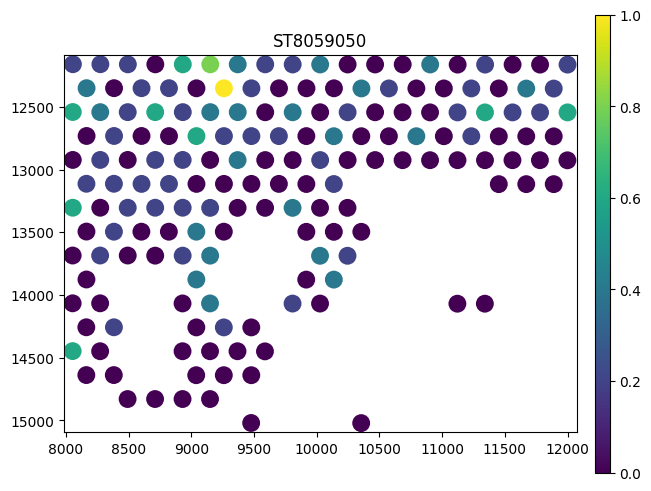

In [19]:
cropped_sdata.pl.render_shapes(color="Sox2").pl.show()

ST8059050## Transformations are preserved after spatial query

Importantly, transformations are preserved in the spatial query result such that the resulting data are still positioned correctly within their target coordinate system. Notice below that the `cropped_sdata` image now has an translation that accounts for the fact that the image has been cropped. Additionally, when we plot the `cropped_sdata` overlaid on the original `sdata_ST8059050`, we see that it remains positioned correctly.

In [21]:
sdata_ST8059050.images["ST8059050_image"]

<xarray.SpatialImage 'ST8059050_image' (c: 3, y: 2000, x: 1968)>
dask.array<from-zarr, shape=(3, 2000, 1968), dtype=uint8, chunksize=(3, 2000, 1968), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 0 1 2
  * y        (y) float64 0.5 1.5 2.5 3.5 ... 1.996e+03 1.998e+03 1.998e+03 2e+03
  * x        (x) float64 0.5 1.5 2.5 3.5 ... 1.966e+03 1.966e+03 1.968e+03
Attributes:
    transform:  {'ST8059050': Scale (c, y, x)\n    [1.        8.6670002 8.667...

In [22]:
cropped_sdata.images["ST8059050_image"]

<xarray.SpatialImage 'ST8059050_image' (c: 3, y: 461, x: 462)>
dask.array<getitem, shape=(3, 461, 462), dtype=uint8, chunksize=(3, 461, 462), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 0 1 2
  * y        (y) float64 0.5 1.5 2.5 3.5 4.5 ... 456.5 457.5 458.5 459.5 460.5
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 457.5 458.5 459.5 460.5 461.5
Attributes:
    transform:  {'ST8059050': Sequence \n    Translation (x, y)\n        [ 92...

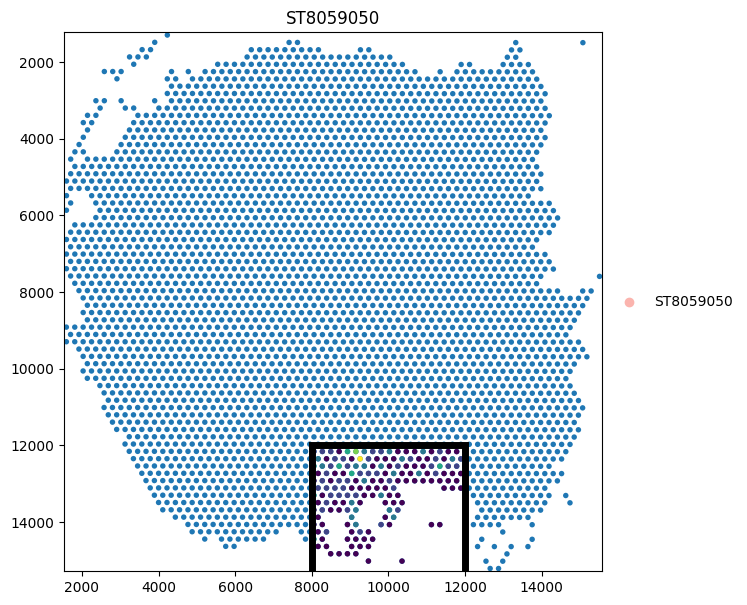

In [24]:
f, ax = plt.subplots(figsize=(7, 7))
sdata_ST8059050.pl.render_shapes(color="library", palette="Pastel1").pl.show(ax=ax)
cropped_sdata.pl.render_shapes(color="Sox2").pl.show(ax=ax, colorbar=False)

# show the spatial query bounding box
rect = patches.Rectangle((8000, 12000), 4000, 4000, linewidth=5, edgecolor="k", facecolor="none")
ax.add_patch(rect)